In [3]:
%matplotlib widget
%cd /data/seismo/kashyap/codes/p11-seismo-xl

/data/seismo/kashyap/codes/p11-seismo-xl


In [4]:
%run compute_delnu.py --help

usage: compute_delnu.py [-h] [--kic KIC] [--lmax LMAX] [--Navg NAVG]
                        [--Nshift NSHIFT] [--inclang INCLANG]
                        [--freqmin FREQMIN] [--freqmax FREQMAX]

Process some integers.

optional arguments:
  -h, --help         show this help message and exit
  --kic KIC          Kepler KIC
  --lmax LMAX        Max ell observed in data
  --Navg NAVG        Length of sub-series (days)
  --Nshift NSHIFT    Shift between sub-series (days)
  --inclang INCLANG  Inclination angle
  --freqmin FREQMIN  Minimum freq in mHz
  --freqmax FREQMAX  Maximum freq in mHz


LOADING SUCESS
(90979,)
(90979,)
----Number of frequency bins = 77760


KeyboardInterrupt: 

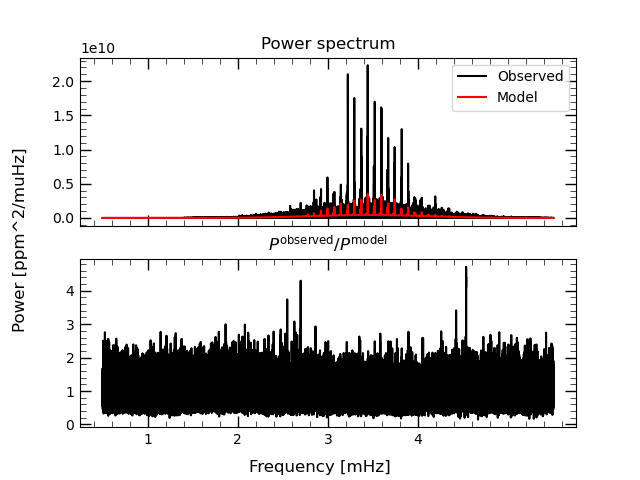

In [5]:
plt.close('all')
%run compute_delnu.py --kic 8006161 --Navg 180 --Nshift 45

In [6]:
PAPDIR

'/scratch/seismo/kashyap/cloud/Yandex.Disk/papers-posters-docs/2025-seismo-xl'

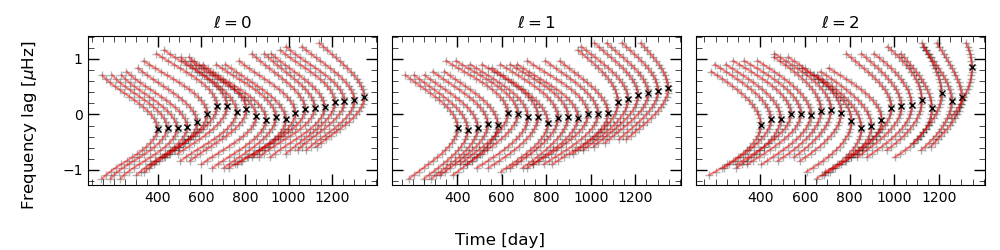

In [34]:
plt.close('all')
from compute_delnu import plot_cc, plot2cc
#fig, axs = plot_cc(pschunks, pfilt_list, pexcl_list, time_arr, fittype='gaussian', dfreq=dfreq)
fig, axs = plot2cc(pschunks, pfilt_list, pexcl_list, time_arr, fittype='polynomial', dfreq=dfreq, numfitpix=15)
fig.savefig(f'{PAPDIR}/ccfit-{kicstr}.pdf')

In [14]:
time_arr[0]

401.4806349578321

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True)
for jdx in range(3):
    for idx in range(len(pschunks)):
        lags, corr = compute_cc(pfilt_list[jdx], pschunks[idx])
        lags_bg, corr_bg = compute_cc(pexcl_list[jdx], pfilt_list[jdx])
        corr2 = corr - corr_bg
        corr2 -= corr2.min()
        corr2 /= corr2.max()
        pf = np.polyfit(lags, corr2, deg=5)
        mfunc = lambda x: -1*np.polyval(pf, x)
        fit = minimize(mfunc, x0=0)
        shifty = 0.3*idx
        axs[jdx].plot(lags*dfreq*1e6, corr2+shifty, '+k')
        axs[jdx].plot(lags*dfreq*1e6, -1*mfunc(lags)+shifty, 'r')
        axs[jdx].text((lags[0]-25)*dfreq*1e6, corr2[0]+shifty, f't ={time_arr[idx]:7.1f}d')
    axs[jdx].set_title('$\\ell =$' + f'{jdx}')
    axs[jdx].set_xlim([(lags[0]-26)*dfreq*1e6, lags[-1]*dfreq*1e6])
fig.supxlabel('Frequency lag [$\\mu$Hz]')

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharex=True, sharey=True)
domega_muhz_santos = []
domega_err_santos = []
for idx in range(ARGS.lmax):
    fint = interp1d(santos_data_avg['time'], santos_data_avg[f'delnu{idx}'], bounds_error=False,)
    finte = interp1d(santos_data_avg['time'], santos_data_avg[f'delnu{idx}_error'], bounds_error=False)
    pbobs = fint(time_arr)
    pbobse = finte(time_arr)
    axs[0, idx].set_title('$\\ell$ = ' + f'{idx}')
    domega_muhz_santos.append(pbobs)
    domega_err_santos.append(pbobse)

# Computing dc shift for different ell
domega_muhz = domega_muhz
ddo = np.array(domega_muhz_santos) - domega_muhz
dcs = np.sqrt(np.diag(ddo @ ddo.T)/ddo.shape[-1])

err_list = []

for idx in range(ARGS.lmax):
    axs[0, idx].set_title('$\\ell$ = ' + f'{idx}')
    pbobs = domega_muhz_santos[idx]
    pbobse = domega_err_santos[idx]
    #axs[idx].errorbar(time_arr, pbobs+dcs[idx], yerr=pbobse, capsize=5, color='r', marker='o', markersize=4, linestyle='')
    #axs[idx].errorbar(time_arr, domega_muhz[idx], yerr=np.ones_like(domega_muhz[idx])*domega_sig[idx], capsize=5, color='k', marker='v', markersize=4, linestyle='') 
    axs[0, idx].plot(time_arr, pbobs+dcs[idx], 'or', markersize=4, label='Santos et. al. (2018)')
    axs[0, idx].plot(time_arr, domega_muhz[idx], 'xk', markersize=3, label='This work')
    axs[0, idx].fill_between(time_arr, pbobs+dcs[idx]-pbobse, y2=pbobs+dcs[idx]+pbobse, color='r', alpha=0.3)
    axs[0, idx].fill_between(time_arr, domega_muhz[idx]-domega_sig[idx], y2=domega_muhz[idx]+domega_sig[idx], color='k', alpha=0.3)
    axs[1, idx].plot(time_arr, pbobs+dcs[idx] - domega_muhz[idx], '+k', markersize=3)
    axs[1, idx].fill_between(time_arr, -np.ones_like(domega_muhz[idx])*domega_sig[idx], y2=np.ones_like(domega_muhz[idx])*domega_sig[idx], color='k', alpha=0.2)
    err_list.append(pbobs+dcs[idx] - domega_muhz[idx])
fig.supxlabel('Time [day]', fontsize=14)
fig.supylabel('$\\delta\\omega_\\ell$ in $\\mu$Hz', fontsize=14)
fig.tight_layout()

In [ ]:
for idx in range(3):
    print(np.corrcoef(err_list[idx], domega_muhz_santos[idx])[0, 1])

In [ ]:
dcs

In [ ]:
a2g = amps*amps/fwhm

In [ ]:
fig, axs = plt.subplots(figsize=(5, 3))
for ell, _mask in enumerate([mask0, mask1, mask2, mask3]):
    wnl = a2g[_mask]/a2g[_mask].sum()
    _nu = nus[_mask]*1e6
    axs.plot(_nu, wnl, '-o', label=f'ell = {ell}', lw=0.5)
axs.set_xlabel('Mode frequency [$\\mu$Hz]', fontsize=12)
axs.set_ylabel('$w_{n\\ell}$', fontsize=12)
axs.set_title('KIC 8006161')
axs.legend()
fig.tight_layout()
fig.savefig('/scratch/seismo/kashyap/cloud/Yandex.Disk/papers-posters-docs/2025-seismo-xl/wnl-8006161.png')

In [ ]:
xax = np.arange(pschunks.shape[0])
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=(10, 8))
axs[0, 0].imshow(corr_mat[0].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[0, 0].plot(xax+0.5, corr_matarg[0], 'r')
axs[1, 0].imshow(corr_mat[1].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[1, 0].plot(xax+0.5, corr_matarg[1], 'r')
axs[2, 0].imshow(corr_mat[2].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[2, 0].plot(xax+0.5, corr_matarg[2], 'r')
axs[3, 0].imshow(corr_mat[3].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[3, 0].plot(xax+0.5, corr_matarg[3], 'r')

axs[0, 1].imshow(corr_mat_gauss[0].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[0, 1].plot(xax+0.5, corr_matarg_gauss[0], 'r')
axs[1, 1].imshow(corr_mat_gauss[1].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[1, 1].plot(xax+0.5, corr_matarg_gauss[1], 'r')
axs[2, 1].imshow(corr_mat_gauss[2].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[2, 1].plot(xax+0.5, corr_matarg_gauss[2], 'r')
axs[3, 1].imshow(corr_mat_gauss[3].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[3, 1].plot(xax+0.5, corr_matarg_gauss[3], 'r')

axs[0, 2].plot(xax+0.5, corr_matarg[0], '.'); axs[0, 2].plot(xax+0.5, corr_matarg_gauss[0], '-r')
axs[1, 2].plot(xax+0.5, corr_matarg[1], '.'); axs[1, 2].plot(xax+0.5, corr_matarg_gauss[1], '-r')
axs[2, 2].plot(xax+0.5, corr_matarg[2], '.'); axs[2, 2].plot(xax+0.5, corr_matarg_gauss[2], '-r')
axs[3, 2].plot(xax+0.5, corr_matarg[3], '.'); axs[3, 2].plot(xax+0.5, corr_matarg_gauss[3], '-r')
for idx in range(4): 
    axs[idx, 0].set_title(f'ell={idx} [Max corr in red]')
    axs[idx, 1].set_title(f'ell={idx} [Max gauss-fit in red]')
    axs[idx, 2].set_title(f'ell={idx} [Max corr, gauss-fit]')
fig.supylabel('$\\bar{\\delta\\nu}_\\ell$ in $\\mu$Hz')